In [1]:
import pandas as pd
import dask
import xarray as xr # Need it for the aggregation of the normalized matrix...
import numpy as np
import geopandas as gpd
import atlite
import logging
from shapely.geometry import Point
from collections import namedtuple
import cartopy.crs as ccrs
import cartopy.io.shapereader as shpreader
from cartopy.crs import PlateCarree as plate
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec
import xarray as xr
from scipy.sparse import csr_matrix, find
logging.basicConfig(level=logging.INFO)

### Loading


In [2]:
def get_map(countries):
    '''Gets background map to plot over.
    
    Args: 
        countries: List of countries

    Returns: 
        Geoseries representing map
    ''' 

    # Check type 
    if not isinstance(countries, list): 
        logging.error('Type error. Input as list')
        return 

    # Use the shapereader of Cartopy to retrieve hight resolution shapes
    shpfilename = shpreader.natural_earth(
        resolution='10m',
        category='cultural',
        name='admin_0_countries')
    reader = shpreader.Reader(shpfilename)

    # Make a GeoSeries with the shapes
    area = gpd.GeoSeries(
        {r.attributes['NAME_EN']: r.geometry for r in reader.records()},
        crs={'init': 'epsg:4326'}).reindex(countries)
        
    return area

This notebook is used to create the generation profiles of:

    - Run-of-river
    - Wind
    - Solar

**Using ERA5 for now**

In [4]:
# Create cutout
# This is object or landscape where data will be geolocated to?
cutout_path = r"/mnt/c/Users/pmcw9/Delta-E/PICS/Data/cutout/"
# before as cutout can take up a lot of disk space and time...
# bound are fore Metro Vancouver only right now...
# bounds = [-124,-121,49,50] # [West, East, South, North] bounds of region of interest (BC) (must be integer?) (Collecting Lower-Mainland)
bounds = [-120,-115,48,53] # [West, East, South, North] Columbia river system 
# LOOK INTO dx,dy
cutout = atlite.Cutout(path=cutout_path + "/columbia_cutout_2021.nc",
                       module="era5",
                       x=slice(bounds[0],bounds[1]),
                       y=slice(bounds[2],bounds[3]),
                       time=slice("2021-01","2021-12"))

# Add argument of prepared features to reduce complexity

# Processing of the cutout... (runtime = 6 m 29.8s, 1 month) Lower-Mainland
# Processing of the cutout... (runtime = 75 m 23.8s, 1 year) Columbia River System (BC portion only)
cutout.prepare()

INFO:atlite.cutout:Building new cutout /mnt/c/Users/pmcw9/Delta-E/PICS/Data/cutout/columbia_cutout_2021.nc
INFO:atlite.data:Storing temporary files in /tmp/tmp4rih8qrs
INFO:atlite.data:Calculating and writing with module era5:
INFO:atlite.datasets.era5:Requesting data for feature temperature...
INFO:atlite.datasets.era5:Requesting data for feature influx...
INFO:atlite.datasets.era5:Requesting data for feature runoff...
INFO:atlite.datasets.era5:Requesting data for feature wind...
INFO:atlite.datasets.era5:Requesting data for feature height...
INFO:atlite.datasets.era5:CDS: Downloading variables
	 * runoff (2021)

INFO:atlite.datasets.era5:CDS: Downloading variables
	 * geopotential (2021)

INFO:atlite.datasets.era5:CDS: Downloading variables
	 * 2m_temperature (2021)
	 * soil_temperature_level_4 (2021)

INFO:atlite.datasets.era5:CDS: Downloading variables
	 * surface_net_solar_radiation (2021)
	 * surface_solar_radiation_downwards (2021)
	 * toa_incident_solar_radiation (2021)
	 * tot

[########################################] | 100% Completed | 10.6s


<Cutout "columbia_cutout_2021">
 x = -120.00 ⟷ -115.00, dx = 0.25
 y = 48.00 ⟷ 53.00, dy = 0.25
 time = 2021-01-01 ⟷ 2021-12-31, dt = H
 module = era5
 prepared_features = ['height', 'wind', 'influx', 'temperature', 'runoff']

In [5]:
cutout.available_features

module  feature    
era5    height                   height
        wind                    wnd100m
        wind                wnd_azimuth
        wind                  roughness
        influx               influx_toa
        influx            influx_direct
        influx           influx_diffuse
        influx                   albedo
        influx           solar_altitude
        influx            solar_azimuth
        temperature         temperature
        temperature    soil temperature
        runoff                   runoff
Name: variables, dtype: object

In [3]:
# load cutout
cutout_path = r"/mnt/c/Users/pmcw9/Delta-E/PICS/Data/cutout/"
cutout = atlite.Cutout(path=cutout_path + "/columbia_cutout_2021.nc")

### Wind Plots

In [8]:
central_lon = -115
central_lat = 45
projection = ccrs.Orthographic(central_lon, central_lat)

INFO:atlite.convert:Convert and aggregate 'wind'.
/tmp/ipykernel_469/1151062523.py:10: DeprecationWarning: The outline_patch property is deprecated. Use GeoAxes.spines['geo'] or the default Axes properties instead.
  ax.outline_patch.set_edgecolor('white')


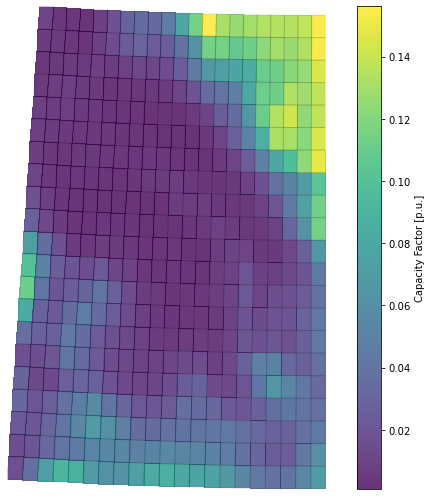

In [9]:
cap_factors = cutout.wind(turbine='Vestas_V112_3MW', capacity_factor=True)
cells = cutout.grid
plot_grid_dict = dict(alpha=0.1, edgecolor='k', zorder=4, aspect='equal',
                      facecolor='None', transform=plate())

fig, ax = plt.subplots(subplot_kw={'projection': projection}, figsize=(9, 7))
cap_factors.name = 'Capacity Factor'
cap_factors.plot(ax=ax, transform=plate(), alpha=0.8)
cells.plot(ax=ax, **plot_grid_dict)
ax.outline_patch.set_edgecolor('white')
fig.tight_layout();

/home/pmcwhannel/anaconda3/envs/bc-power/lib/python3.10/site-packages/pyproj/crs/crs.py:130: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
/tmp/ipykernel_469/2468620940.py:41: DeprecationWarning: The outline_patch property is deprecated. Use GeoAxes.spines['geo'] or the default Axes properties instead.
  ax.outline_patch.set_edgecolor('white')


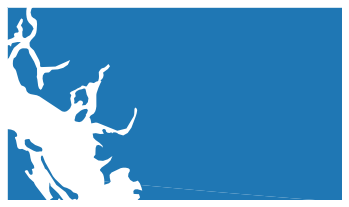

In [10]:
# Plotting of the cutout
_PLOT_GRID_DICT = dict(
    alpha=0.1, 
    edgecolor='k', 
    zorder=4, 
    aspect='equal',
    facecolor='None', 
    transform=plate())

_MAP_COUNTRIES = ['Canada', 'United States of America']

# projection 
central_lon = -115
central_lat = 45
projection = ccrs.Orthographic(central_lon, central_lat)
# create and save grid overlay 
bounds = [-124,-121,49,50] 
fig, ax = plt.subplots(subplot_kw={'projection': projection},
                        figsize=(6, 6))

# check keyword arguments 
map_countries = _MAP_COUNTRIES 

# Create GeoSeries with cell relevent data
cells = cutout.grid
land_area = get_map(map_countries) # countries:geometry
cell_area = gpd.GeoSeries(cells.unary_union)

# Plot land area background
land_area.plot(ax=ax, zorder=1, transform=plate())

# Plot Grid
cells.plot(ax=ax, **_PLOT_GRID_DICT)

cell_area.plot(
    ax=ax, 
    edgecolor='orange',
    facecolor='None', 
    transform=plate())

ax.outline_patch.set_edgecolor('white')

# Adjust plotting axis
if bounds:
    ax.set_extent([
        bounds[0],
        bounds[1],
        bounds[2],
        bounds[3]], crs=ccrs.PlateCarree())

# plot_grid(cutout, ax, plot_grid_dict=_PLOT_GRID_DICT, bounds=bounds)
# fig.savefig('results/figures/grid.png')

/tmp/ipykernel_406/903679124.py:12: DeprecationWarning: The outline_patch property is deprecated. Use GeoAxes.spines['geo'] or the default Axes properties instead.
  ax.outline_patch.set_edgecolor('white')


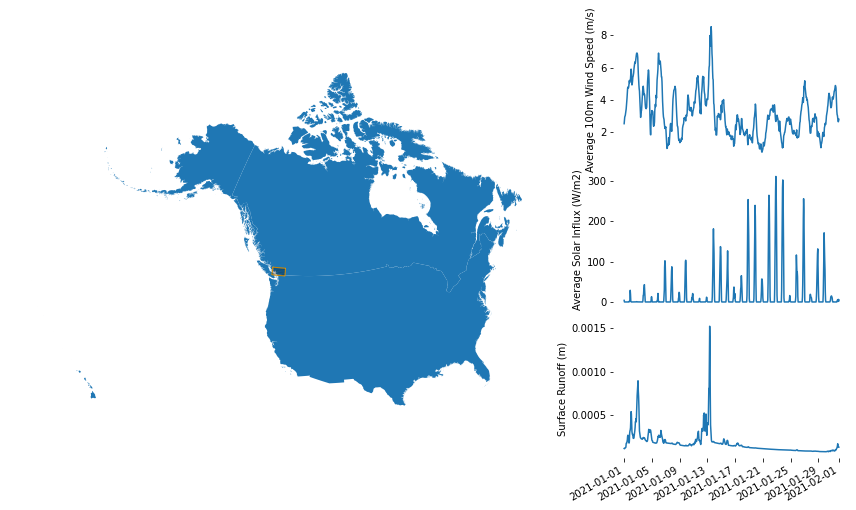

In [29]:
## Plotting of wind, solar, and runoff
fig = plt.figure(figsize=(12, 7))
gs = GridSpec(3, 3, figure=fig)

ax = fig.add_subplot(gs[:, 0:2], projection=projection)
plot_grid_dict = dict(alpha=0.1, edgecolor='k', zorder=4, aspect='equal',
                      facecolor='None', transform=plate())
land_area.plot(ax=ax, zorder=1, transform=plate())
cells.plot(ax=ax, **plot_grid_dict)
cell_area.plot(ax=ax, edgecolor='orange',
                   facecolor='None', transform=plate())
ax.outline_patch.set_edgecolor('white')

ax1 = fig.add_subplot(gs[0, 2])
cutout.data.wnd100m.mean(['x', 'y']).plot(ax=ax1)
ax1.set_frame_on(False)
ax1.set_ylabel('Average 100m Wind Speed (m/s)')
ax1.xaxis.set_visible(False)

ax2 = fig.add_subplot(gs[1, 2], sharex=ax1)
cutout.data.influx_direct.mean(['x', 'y']).plot(ax=ax2)
ax2.set_frame_on(False)
ax2.set_ylabel('Average Solar Influx (W/m2)')
ax2.xaxis.set_visible(False)

ax3 = fig.add_subplot(gs[2, 2], sharex=ax1)
cutout.data.runoff.mean(['x', 'y']).plot(ax=ax3)
ax3.set_frame_on(False)
ax3.set_ylabel('Surface Runoff (m)')
ax3.set_xlabel(None)
fig.tight_layout()

### Plotting of the wind power generation

In [142]:
# This code calculates the cells/grids for where generation exists 
# Cells of the cutout
cells = cutout.grid 

#site: location of the termines with latitudes and longitudes specified
sites = gpd.GeoDataFrame([['Abbostsford', -122.310817, 49.045174, 10],
                          ['Vancouver', -123.134549, 49.287283, 10]],
                         columns=['name', 'lon', 'lat', 'capacity']
                         ).set_index('name')

# Finds cutout cells nearest to (lat,lon) of each site 
# (x,y) of cells/grids are the center points by default and correspong to (lat,lon) of the cells.
nearest = cutout.data.sel(
    {'x': sites.lon.values, 'y': sites.lat.values}, 'nearest').coords

# Add new columns for the grid (x,y) where each generator falls.
sites['x'] = nearest.get('x').values
sites['y'] = nearest.get('y').values

# Performs an inner join on the (x,y) values
cells_generation = sites.merge(
    cells, how='inner').rename(pd.Series(sites.index))

# Layout indicates the installed capacity and grid location of installed capacity
layout = xr.DataArray(cells_generation.set_index(['y', 'x']).capacity.unstack())\
                    .reindex_like(cap_factors).rename('Installed Capacity [MW]')

# Finally generate the power produced at these sites
# Returns the power generation of the generators for each location
# The data is returned as an xarray with shape of (timesteps, generators)
power_generation = cutout.wind(turbine = "Vestas_V112_3MW",
                                layout = layout,
                                shapes = cells_generation.geometry,
                                per_unit = True) # currently using per-unit

INFO:atlite.convert:Convert and aggregate 'wind'.


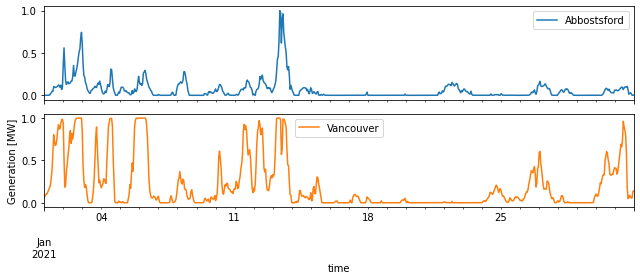

In [143]:
# Plotting of the power generation
fig, axes = plt.subplots(len(sites), sharex=True, figsize=(9, 4))
power_generation.to_pandas().plot(subplots=True, ax=axes)
axes[0].set_xlabel('date')
axes[1].set_ylabel('Generation [MW]')
fig.tight_layout()

### Run-of-river and hydroelectric dams

In [198]:
# read in hydro basin data used for calculating hydro ???
source_file = r"/mnt/c/Users/pmcw9/Delta-E/PICS/Data/hydroBASINS/" + 'hybas_na_lev12_v1c.shp'
basin_data = gpd.read_file(source_file)

In [202]:
# This code calculates the cells/grids for where generation exists 
# Cells of the cutout
cells = cutout.grid

# capacity factor for runoff (not really important)
# only used for getting structure not values
cap_factors = cutout.runoff()

#site: location of the termines with latitudes and longitudes specified
sites = gpd.GeoDataFrame([['Mica', -118.565260, 52.078632, 2971],
                            ['Revelstoke', -118.192934, 51.050299, 2500]],
                         columns=['name', 'lon', 'lat', 'capacity']
                         ).set_index('name')

# sites =   gpd.GeoDataFrame([['Revelstoke', -118.192934, 51.050299, 2500]],
#                          columns=['name', 'lon', 'lat', 'capacity']
#                          ).set_index('name')                       

# Finds cutout cells nearest to (lat,lon) of each site 
# (x,y) of cells/grids are the center points by default and correspong to (lat,lon) of the cells.
# Notes: cutouts has coordinates centered for each cell...
nearest = cutout.data.sel(
    {'x': sites.lon.values, 'y': sites.lat.values}, 'nearest').coords

# Add new columns for the grid (x,y) where each generator falls.
sites['x'] = nearest.get('x').values
sites['y'] = nearest.get('y').values

# Performs an inner join on the (x,y) values
cells_generation = sites.merge(
    cells, how='inner').rename(pd.Series(sites.index))

# Layout indicates the installed capacity and grid location of installed capacity
layout = xr.DataArray(cells_generation.set_index(['y', 'x']).capacity.unstack())\
                    .reindex_like(cap_factors).rename('Installed Capacity [MW]')

# Finally generate the power produced at these sites
# Returns the power generation of the generators for each location
# The data is returned as an xarray with shape of (timesteps, generators)
# Assumed units are m^3/hr for inflow, from 
# https://github.com/PyPSA/atlite/blob/fa17b15e9478aba9565186c48bcac31ab488de85/atlite/convert.py
# but not conclusive.
flowspeed = 1 # Should be investigated to better estimate
inflow = cutout.hydro(sites, basin_data, flowspeed=flowspeed, weight_with_height=False, show_progress=True)
                # weight_with_height.. need to look into the affect of this...
            

INFO:atlite.convert:Convert and aggregate 'runoff'.
Determine upstream basins per plant: 2it [00:02,  1.49s/it]
INFO:atlite.convert:Convert and aggregate 'runoff'.
Shift and aggregate runoff by plant: 2it [00:00,  3.35it/s]


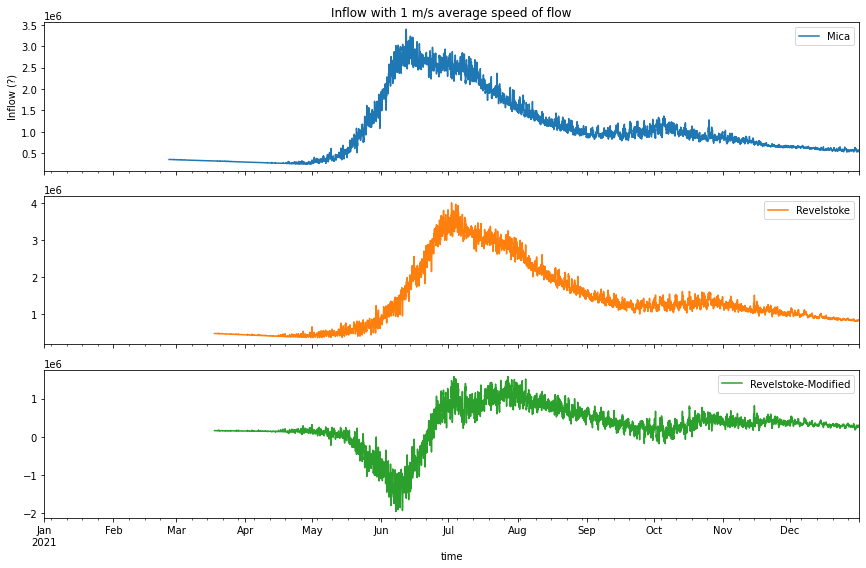

In [203]:
# Transpose and remove Abbostsford because of NaN
# inflow_arr = inflow.to_pandas().T.drop("Abbostsford", axis=1)
inflow_arr = inflow.to_pandas().T * (24/1000)
diff_arr = inflow_arr.iloc[:,1] - inflow_arr.iloc[:,0]
inflow_arr['Revelstoke-Modified'] = diff_arr

# Plotting of the power generation
fig, axes = plt.subplots(inflow_arr.shape[1], sharex=True, figsize=(12, 8))
inflow_arr.plot(subplots=True, ax=axes)
axes[0].set_xlabel('date')
axes[0].set_ylabel('Inflow (?)')
axes[0].set_title(f'Inflow with {flowspeed} m/s average speed of flow')
fig.tight_layout()

# Change flow to 0.1 average speed of flow...